# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 1. NLP.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [1]:
base_dir = '../' # To run locally

# 1. Data pre-processing

In [2]:
#!pip install pycaret[full]

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
#spacy.load("en_core_web_sm")


# NLTK
import string
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/juan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading data

In [4]:
data = pd.read_csv(base_dir + 'data/mount_etna_data.csv')
data = data[['author', 'title', 'content', 'rating']]

# Dropping rows without data in content
data = data.dropna(subset = ['content']).reset_index(drop=True)

print('Data shape: ', data.shape)
data.head()

Data shape:  (3419, 4)


author                                              title  \
0  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
1               Teithiwr                         A hard climb, but worth it   
2      elizabethlascheid  You must see an active volcano at least once i...   
3                 Anne N                    Cost of cable car to the top???   
4  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                     Wonderful Etna   

                                             content  rating  
0  East side of the sicilian island, in the Catan...       5  
1  August 2008. Arrived at Refugio Sapienza just ...       4  
2  Mount Etna is extraordinary. It is an active v...       5  
3  How much does the cable car cost from Rifugio ...       4  
4  It's always a great and sensational emotion to...       5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   3417 non-null   object
 1   title    3419 non-null   object
 2   content  3419 non-null   object
 3   rating   3419 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.0+ KB


# Filtering comments using EACH keyword, to assess imbalance in dataset

In [6]:
TRANSPORT_KEYWORD = ['transport', 'cable', 'car', 'rail', 'bus', 'transportation', 'mobility', 'bike']


for i in TRANSPORT_KEYWORD:
    # Filtering
    data_filtered = data.copy()
    data_filtered['is_transport_related'] = data_filtered['content'].str.contains(i, case=False, na=False)
    data_filtered = data_filtered[data_filtered['is_transport_related']==True].reset_index(drop=True)
    data_filtered = data_filtered.drop(columns=['is_transport_related'])

    # Creating sentiment_rating feature based on rating
    data_filtered['sentiment_rating'] = np.where(data_filtered['rating'] > 3,1,0)
    #TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

    # changing bad and good just for visualization in the recall metric
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace([0,1],['negative', 'positive'])
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!



    # Printing datasets    
    print('Dataset using keyword: {}.'.format(i))
    print('Data shape: ', data_filtered.shape)
    print(data_filtered['sentiment_rating'].value_counts(normalize=True))
    display(data_filtered.head(10))
    print('--------------')

Dataset using keyword: transport.
Data shape:  (76, 5)
0    0.907895
1    0.092105
Name: sentiment_rating, dtype: float64


author                                              title  \
0           John O  Mount Etna - AST bus from Catania, cable car a...   
1  Faithalicious_x  More fun than I was expecting, easy enough by ...   
2            lihte                                 top craters - etna   
3          Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4      relloggrion                                              GREAT   
5          Makence                           Loved our stay in Sicily   
6         VikramVI  How can you make visit awesome, lots of tips f...   
7          Donna K                                    The Full Monte    
8        Bath_Rich          Unbelievable and unforgettable experience   
9        Quentin C  Definitely Take a Guided Tour for the Best Exp...   

                                             content  rating  sentiment_rating  
0  Mount Etna is a stunning day out from Catania....       4                 0  
1  I arrived at Etna using public transport and v...       5                 0  
2  Hi,,We have just climbed etna on the 6th of ju...       5                 0  
3  Kudos to Sicily Life for providing my group of...       5                 0  
4  we visited mount Etna in August 2010 and had a...       4                 0  
5  Me and my boyfriend went to Sicily at the end ...       5                 0  
6  - You can make your trip to this must visit Vo...       5                 0  
7  Really enjoyed the trip to Mount Etna. The sce...       4                 0  
8  This is the main reason I wanted to visit Sici...       5                 0  
9  My family and I considered going up Mt. Etna b...       5                 0

--------------
Dataset using keyword: cable.
Data shape:  (1352, 5)
0    0.888314
1    0.111686
Name: sentiment_rating, dtype: float64


author                                              title  \
0       Teithiwr                         A hard climb, but worth it   
1         Anne N                    Cost of cable car to the top???   
2  doorstomanual                       Well orgainised, easy access   
3       Emilie P                   Cheap and easy way to do Mt Etna   
4     Jonathan L        Question about Etna Cable Cars and children   
5         John O  Mount Etna - AST bus from Catania, cable car a...   
6       koenevie                        walk mount etna on your own   
7         Gunnel                                           Stunning   
8         Agil N            Spectacular drive up Mount Etna, Sicily   
9    tugcrumpton  One earring to rule them all but take a coat a...   

                                             content  rating  sentiment_rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4                 0  
1  How much does the cable car cost from Rifugio ...       4                 0  
2  We visited Etna with two small children in Aug...       5                 0  
3  We were able to experience Mt Etna without spe...       5                 0  
4  We would like to visit Etna. We have a 3 year ...       5                 0  
5  Mount Etna is a stunning day out from Catania....       4                 0  
6  If you are in good condition, you can climb th...       5                 0  
7  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
8  We wanted to see Mount Etna whilst holidaying ...       4                 0  
9  My beloved and I were chatting about various t...       4                 0

--------------
Dataset using keyword: car.
Data shape:  (1629, 5)
0    0.897483
1    0.102517
Name: sentiment_rating, dtype: float64


author                                              title  \
0           Teithiwr                         A hard climb, but worth it   
1  elizabethlascheid  You must see an active volcano at least once i...   
2             Anne N                    Cost of cable car to the top???   
3      doorstomanual                       Well orgainised, easy access   
4           Emilie P                   Cheap and easy way to do Mt Etna   
5         Jonathan L        Question about Etna Cable Cars and children   
6             John O  Mount Etna - AST bus from Catania, cable car a...   
7           koenevie                        walk mount etna on your own   
8             Gunnel                                           Stunning   
9             Agil N            Spectacular drive up Mount Etna, Sicily   

                                             content  rating  sentiment_rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4                 0  
1  Mount Etna is extraordinary. It is an active v...       5                 0  
2  How much does the cable car cost from Rifugio ...       4                 0  
3  We visited Etna with two small children in Aug...       5                 0  
4  We were able to experience Mt Etna without spe...       5                 0  
5  We would like to visit Etna. We have a 3 year ...       5                 0  
6  Mount Etna is a stunning day out from Catania....       4                 0  
7  If you are in good condition, you can climb th...       5                 0  
8  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
9  We wanted to see Mount Etna whilst holidaying ...       4                 0

--------------
Dataset using keyword: rail.
Data shape:  (95, 5)
0    0.947368
1    0.052632
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1         Itchy2Feet                        Watch out for the clouds...   
2        tugcrumpton  One earring to rule them all but take a coat a...   
3       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
4               NMMc                               Hiking on Mount Etna   
5           Stuart C  Amazing trek from Rifugio Citelli to Etna Nord...   
6             Liffey                                 It has to be done!   
7            Janet G                                       Unique hike!   
8               krc2  Mt Etna Sud Gondola free parking at GPS: N37.7...   
9          Flashduck  Get away from the tourists and walk up the lav...   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  Mt Etna is of course a "must visit", but be wa...       4                 0  
2  My beloved and I were chatting about various t...       4                 0  
3  There are at least 4 different tour companies ...       5                 0  
4  We visited Mount Etna during June 2014 when it...       5                 0  
5  We wanted to climb Etna on a quiet route away ...       5                 0  
6  It woud be a sin to visit this region of Sicil...       5                 0  
7  Reliable information on visiting Etna is somew...       5                 0  
8  Mt Etna Sud Gondola free parking at GPS: N37.7...       5                 0  
9  There are many bus tours offering tours to Mt ...       5                 0

--------------
Dataset using keyword: bus.
Data shape:  (932, 5)
0    0.887339
1    0.112661
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1      doorstomanual                       Well orgainised, easy access   
2             John O  Mount Etna - AST bus from Catania, cable car a...   
3             Gunnel                                           Stunning   
4        tugcrumpton  One earring to rule them all but take a coat a...   
5          Jimski777                                 Hiking on Mt. Etna   
6       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
7     NickyPAberdeen              Going up Etna is very straightforward   
8       ChoosyChoosa  MOUNT ETNA OR A RIP-OFF CRATER & a great gimmi...   
9             Stinz3                                            A must!   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  We visited Etna with two small children in Aug...       5                 0  
2  Mount Etna is a stunning day out from Catania....       4                 0  
3  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
4  My beloved and I were chatting about various t...       4                 0  
5  This review will start with some practical inf...       4                 0  
6  There are at least 4 different tour companies ...       5                 0  
7  Some reviews on this site imply that ascending...       5                 0  
8  Over 90% of reviewers offer 4- or 5-star ratin...       1                 1  
9  We drove up to the Rifugio Sapienza station, l...       5                 0

--------------
Dataset using keyword: transportation.
Data shape:  (21, 5)
0    0.857143
1    0.142857
Name: sentiment_rating, dtype: float64


author                                              title  \
0            lihte                                 top craters - etna   
1          Makence                           Loved our stay in Sicily   
2        Quentin C  Definitely Take a Guided Tour for the Best Exp...   
3  Maja Stojanovic                                          WORTH IT!   
4         SzonjaHU                   Not easy from Catania, but worth   
5        baydreams                        Easy route, awesome sights!   
6    Colin_of_Cork                        Lunar terrain here on Earth   
7        parOFdice                                         Great walk   
8          Sarah T                                   Not to be missed   
9          Petru S             Best tour guide to summit Etna (3320m)   

                                             content  rating  sentiment_rating  
0  Hi,,We have just climbed etna on the 6th of ju...       5                 0  
1  Me and my boyfriend went to Sicily at the end ...       5                 0  
2  My family and I considered going up Mt. Etna b...       5                 0  
3  Climbing Etna was one of my favorite experienc...       5                 0  
4  If you choose to go to Etna by public transpor...       5                 0  
5  Two of us went to see Mt Etna up-close as part...       5                 0  
6  We made our way by car from Catania up to Rifu...       4                 0  
7  Vulcano Etna offers many options to spend an e...       5                 0  
8  Mount Etna is definitely a must-see on any vis...       5                 0  
9  Listen, I know that finding a tour guide for v...       5                 0

--------------
Dataset using keyword: mobility.
Data shape:  (10, 5)
0    0.9
1    0.1
Name: sentiment_rating, dtype: float64


author                                              title  \
0  Faithalicious_x  More fun than I was expecting, easy enough by ...   
1           Liffey                                 It has to be done!   
2          Brent O   How to Drive to the Mount Etna Funivia (Gondola)   
3      EnnisParker   An amazing experience thats worth the tough hike   
4         SazBowen                                        Fantastico!   
5         Nicola D             Excellent Trip, Mount Etna is AMAZING!   
6        Suzanne P                    An experience not to be missed.   
7      mike-john-c                            There is no easy option   
8           Morrso                                            Amazing   
9        Phyllis G                                A Must do in Sicily   

                                             content  rating  sentiment_rating  
0  I arrived at Etna using public transport and v...       5                 0  
1  It woud be a sin to visit this region of Sicil...       5                 0  
2  We found the existing reviews of Mt. Etna to b...       4                 0  
3  Epic! We took the 8:15am public bus there from...       5                 0  
4  We did the trip to Mount Etna on our own steam...       5                 0  
5  We arrived at a mini-village/tourist area of s...       5                 0  
6  Booked with Sat Tours before we left home to e...       5                 0  
7  We are both elderly and my wife, who walks wit...       2                 1  
8  Go early and beat the tour buses! The place wa...       5                 0  
9  We took one of the many available tours of Mt....       4                 0

--------------
Dataset using keyword: bike.
Data shape:  (25, 5)
0    0.96
1    0.04
Name: sentiment_rating, dtype: float64


author                                              title  \
0  juanjuanjohn  The Mount Etna-one of Italy’s most popular des...   
1       Donna K                                    The Full Monte    
2        Shel H            Etna People gave us a perfect eperience   
3     Ewingston                      One more off the bucket list!   
4        Tony B              It's a volcano, a must see and climb    
5      Andrei G  Very nice but pricy. Choose good weather for v...   
6   jdevans2017                                    Amazing day out   
7    Tiffanie P             Spectacular views. Adventurous ride up   
8      701David                                      Underwhelming   
9      Dervla M                         Mountainbiking around Etna   

                                             content  rating  sentiment_rating  
0  Mount Etna is less than twenty miles from Sici...       5                 0  
1  Really enjoyed the trip to Mount Etna. The sce...       4                 0  
2  We booked an excellent half-day tour with Etna...       5                 0  
3  I doubt if many people come to North East Sici...       5                 0  
4  Etna. We drove to the 2000 m  point, which is ...       5                 0  
5  128€ for two... But we had English speaking gu...       4                 0  
6  A proper adventure - start at the bus station ...       5                 0  
7  We visited Mount Etna on the south side at the...       5                 0  
8  We had come to Sicily to experience Monte Etna...       2                 1  
9  This was very special. Luca Maugeri at Mongibe...       5                 0

--------------


## Filtering comments according to keywords

In [7]:
TRANSPORT_KEYWORDS = 'transport|rail|cable|car|bus|transportation|mobility|bike'

In [8]:
# Filtering
data['is_transport_related'] = data['content'].str.contains(TRANSPORT_KEYWORDS, case=False, na=False)
data = data[data['is_transport_related']==True].reset_index(drop=True)
data = data.drop(columns=['is_transport_related'])

# New dataset
print('Data shape: ', data.shape)
data.head(10)

Data shape:  (1947, 4)


author                                              title  \
0           Teithiwr                         A hard climb, but worth it   
1  elizabethlascheid  You must see an active volcano at least once i...   
2             Anne N                    Cost of cable car to the top???   
3      doorstomanual                       Well orgainised, easy access   
4           Emilie P                   Cheap and easy way to do Mt Etna   
5         Jonathan L        Question about Etna Cable Cars and children   
6             John O  Mount Etna - AST bus from Catania, cable car a...   
7           koenevie                        walk mount etna on your own   
8             Gunnel                                           Stunning   
9         Itchy2Feet                        Watch out for the clouds...   

                                             content  rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4  
1  Mount Etna is extraordinary. It is an active v...       5  
2  How much does the cable car cost from Rifugio ...       4  
3  We visited Etna with two small children in Aug...       5  
4  We were able to experience Mt Etna without spe...       5  
5  We would like to visit Etna. We have a 3 year ...       5  
6  Mount Etna is a stunning day out from Catania....       4  
7  If you are in good condition, you can climb th...       5  
8  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5  
9  Mt Etna is of course a "must visit", but be wa...       4

In [9]:
# Creating sentiment_rating feature based on rating
data['sentiment_rating'] = np.where(data['rating'] > 3,1,0)
#TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

# changing bad and good just for visualization in the recall metric
data['sentiment_rating'] = data['sentiment_rating'].replace([0,1],['negative', 'positive'])
data['sentiment_rating'] = data['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!

In [10]:
data['sentiment_rating'].value_counts(normalize=True)

0    0.896251
1    0.103749
Name: sentiment_rating, dtype: float64

#### This data is imbalanced, as 90% of the reviews are positive (4, 5) and just 10% are negative (1, 2, 3)

48445


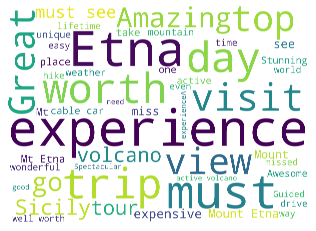

In [11]:
# Wordcloud of title

word_cloud_text = ''.join(data['title'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/title_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

1391438


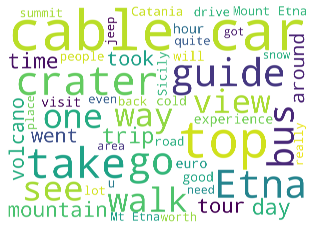

In [12]:
# Wordcloud of content

word_cloud_text = ''.join(data['content'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/content_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

# 3. NLP for title

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            1947 non-null   object
 1   title             1947 non-null   object
 2   content           1947 non-null   object
 3   rating            1947 non-null   int64 
 4   sentiment_rating  1947 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 76.2+ KB


In [14]:
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')

In [15]:
noise_words_title = []
token_lists_title = [word_tokenize(each) for each in data['title']]
tokens_title = [item for sublist in token_lists_title for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_title)))


Number of unique tokens then:  1767


In [16]:
one_percentile_title = int(len(set(tokens_title)) * 0.01)
top_1_percentile_title = Counter(tokens_title).most_common(one_percentile_title)
bottom_1_percentile_title = Counter(tokens_title).most_common()[-one_percentile_title:]

print(top_1_percentile_title[:10])
print('---------------')
print(bottom_1_percentile_title[:10])

[('!', 414), ('the', 297), ('Etna', 257), ('to', 250), ('a', 208), ('experience', 179), (',', 161), ('and', 153), ('of', 150), ('A', 144)]
---------------
[('mind-blowing', 1), ('Recommended', 1), ('major', 1), ('floes', 1), ('Biked', 1), ('completely', 1), ('piece', 1), ('wish', 1), ('dirty', 1), ('Over-rated', 1)]


In [17]:
noise_words_title.extend(eng_stop_words)
noise_words_title.extend([word for word, val in top_1_percentile_title])
noise_words_title.extend([word for word, val in bottom_1_percentile_title])

In [18]:
data

author                                              title  \
0              Teithiwr                         A hard climb, but worth it   
1     elizabethlascheid  You must see an active volcano at least once i...   
2                Anne N                    Cost of cable car to the top???   
3         doorstomanual                       Well orgainised, easy access   
4              Emilie P                   Cheap and easy way to do Mt Etna   
...                 ...                                                ...   
1942        DianaMary60                                        Rocks rock!   
1943            Yaron S                                  Unique experience   
1944            jpg1747                                      Fabulous Tour   
1945              qio_s                                 Exciting adventure   
1946         Hornepayne             Take your Time and Enjoy the Adventure   

                                                content  rating  \
0     August 2008. Arrived at Refugio Sapienza just ...       4   
1     Mount Etna is extraordinary. It is an active v...       5   
2     How much does the cable car cost from Rifugio ...       4   
3     We visited Etna with two small children in Aug...       5   
4     We were able to experience Mt Etna without spe...       5   
...                                                 ...     ...   
1942  I went in a 4-wheel drive car, in company with...       5   
1943  Very unique experience. It's not every day you...       5   
1944  We were a group of 7 - we had a great time vis...       5   
1945  I've been to Catania for 5 months with Erasmus...       5   
1946  Went on 3 different tours with Sicily Life. As...       5   

      sentiment_rating  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1942                 0  
1943                 0  
1944                 0  
1945                 0  
1946                 0  

[1947 rows x 5 columns]

In [19]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['title', 'sentiment_rating']],  
                 target = 'title',
                 session_id = 42,
                 custom_stopwords = noise_words_title
                )

In [20]:
lda_title = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title)
lda_title_data = assign_model(lda_title)

In [21]:
print('Shape of lda_title_data: ', lda_title_data.shape)
display(lda_title_data.head())
print('------')
lda_title_data.describe(include='all')

Shape of lda_title_data:  (1947, 8)


title  sentiment_rating   Topic_0   Topic_1  \
0                                hard                 0  0.125043  0.624875   
1  must see active volcano least life                 0  0.039573  0.173116   
2                  cost cable car top                 0  0.051044  0.847550   
3               orgainise easy access                 0  0.062951  0.811910   
4                      cheap easy way                 0  0.346242  0.528731   

    Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.125046  0.125036        Topic 1                 0.62  
1  0.035888  0.751424        Topic 3                 0.75  
2  0.050012  0.051394        Topic 1                 0.85  
3  0.062580  0.062559        Topic 1                 0.81  
4  0.062516  0.062511        Topic 1                 0.53

------


title  sentiment_rating      Topic_0      Topic_1      Topic_2  \
count   1947       1947.000000  1947.000000  1947.000000  1947.000000   
unique  1106               NaN          NaN          NaN          NaN   
top                        NaN          NaN          NaN          NaN   
freq     319               NaN          NaN          NaN          NaN   
mean     NaN          0.103749     0.247997     0.227419     0.229385   
std      NaN          0.305013     0.225122     0.212051     0.215038   
min      NaN          0.000000     0.022738     0.027799     0.022806   
25%      NaN          0.000000     0.083397     0.083360     0.083345   
50%      NaN          0.000000     0.125083     0.125019     0.125020   
75%      NaN          0.000000     0.283471     0.250000     0.250000   
max      NaN          1.000000     0.873125     0.931595     0.892807   

            Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   1947.000000           1947          1947.000000  
unique          NaN              4                  NaN  
top             NaN        Topic 0                  NaN  
freq            NaN            716                  NaN  
mean       0.295199            NaN             0.579004  
std        0.243559            NaN             0.184924  
min        0.022861            NaN             0.250000  
25%        0.084199            NaN             0.435000  
50%        0.250000            NaN             0.620000  
75%        0.508985            NaN             0.740000  
max        0.913043            NaN             0.930000

## Tuning number of topics

In [22]:
tuned_lda_title = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 2 | AUC : 0.6974


In [23]:
lda_title_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_title.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title_tuned)
lda_title_data_tuned = assign_model(lda_title_tuned)
lda_title_data_tuned = lda_title_data_tuned.add_prefix('Title_')
lda_title_data_tuned['Title_Dominant_Topic'] = lda_title_data_tuned['Title_Dominant_Topic'].replace(' ', '_', regex=True)

In [24]:
print('Shape of lda_title_data_tuned: ', lda_title_data_tuned.shape)
display(lda_title_data_tuned.head())
print('------')
lda_title_data_tuned.describe(include='all')

Shape of lda_title_data_tuned:  (1947, 6)


Title_title  Title_sentiment_rating  Title_Topic_0  \
0                                hard                       0       0.254582   
1  must see active volcano least life                       0       0.924613   
2                  cost cable car top                       0       0.100452   
3               orgainise easy access                       0       0.314285   
4                      cheap easy way                       0       0.618705   

   Title_Topic_1 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
0       0.745418              Topic_1                       0.75  
1       0.075387              Topic_0                       0.92  
2       0.899548              Topic_1                       0.90  
3       0.685715              Topic_1                       0.69  
4       0.381295              Topic_0                       0.62

------


Title_title  Title_sentiment_rating  Title_Topic_0  Title_Topic_1  \
count         1947             1947.000000    1947.000000    1947.000000   
unique        1106                     NaN            NaN            NaN   
top                                    NaN            NaN            NaN   
freq           319                     NaN            NaN            NaN   
mean           NaN                0.103749       0.511112       0.488888   
std            NaN                0.305013       0.260848       0.260848   
min            NaN                0.000000       0.046222       0.057262   
25%            NaN                0.000000       0.250816       0.250491   
50%            NaN                0.000000       0.500000       0.500000   
75%            NaN                0.000000       0.749509       0.749184   
max            NaN                1.000000       0.942738       0.953778   

       Title_Dominant_Topic  Title_Perc_Dominant_Topic  
count                  1947                1947.000000  
unique                    2                        NaN  
top                 Topic_0                        NaN  
freq                   1176                        NaN  
mean                    NaN                   0.722691  
std                     NaN                   0.135330  
min                     NaN                   0.500000  
25%                     NaN                   0.620000  
50%                     NaN                   0.750000  
75%                     NaN                   0.830000  
max                     NaN                   0.950000

In [25]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0                                   hard                       0   
1     must see active volcano least life                       0   
2                     cost cable car top                       0   
3                  orgainise easy access                       0   
4                         cheap easy way                       0   
...                                  ...                     ...   
1942                                rock                       0   
1943                              unique                       0   
1944                       fabulous tour                       0   
1945                            exciting                       0   
1946           take time enjoy adventure                       0   

      Title_Topic_0  Title_Topic_1 Title_Dominant_Topic  \
0          0.254582       0.745418              Topic_1   
1          0.924613       0.075387              Topic_0   
2          0.100452       0.899548              Topic_1   
3          0.314285       0.685715              Topic_1   
4          0.618705       0.381295              Topic_0   
...             ...            ...                  ...   
1942       0.257177       0.742823              Topic_1   
1943       0.749340       0.250660              Topic_0   
1944       0.167242       0.832758              Topic_1   
1945       0.745532       0.254468              Topic_0   
1946       0.102980       0.897020              Topic_1   

      Title_Perc_Dominant_Topic  
0                          0.75  
1                          0.92  
2                          0.90  
3                          0.69  
4                          0.62  
...                         ...  
1942                       0.74  
1943                       0.75  
1944                       0.83  
1945                       0.75  
1946                       0.90  

[1947 rows x 6 columns]

## Wordclouds, bigrams and trigrams for Titles

Wordcloud for Title_Topic_0
0    1064
1     112
Name: Title_sentiment_rating, dtype: int64


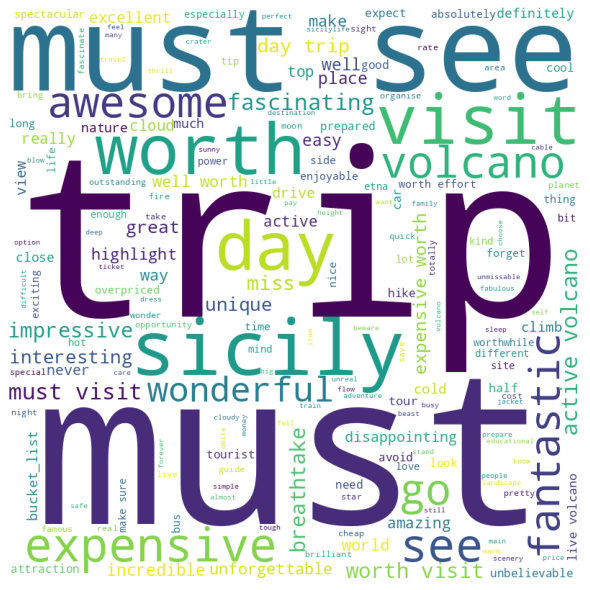

----------------------------------


Wordcloud for Title_Topic_1
0    681
1     90
Name: Title_sentiment_rating, dtype: int64


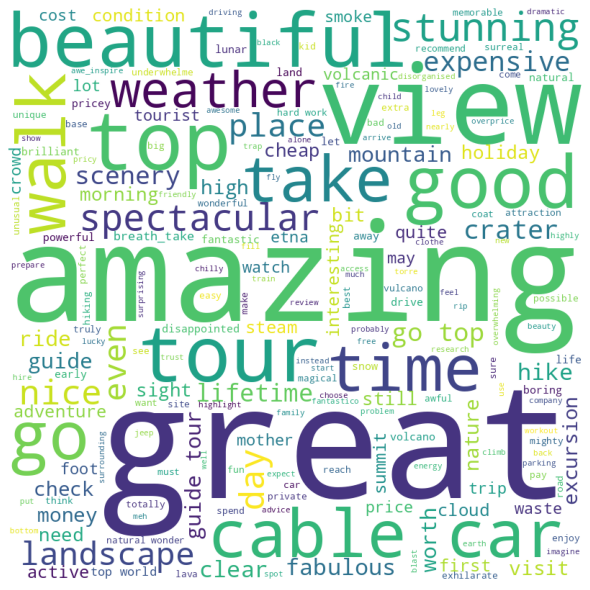

----------------------------------




In [26]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT POSITIVE

Wordcloud for Title_Topic_0
0    1064
Name: Title_sentiment_rating, dtype: int64


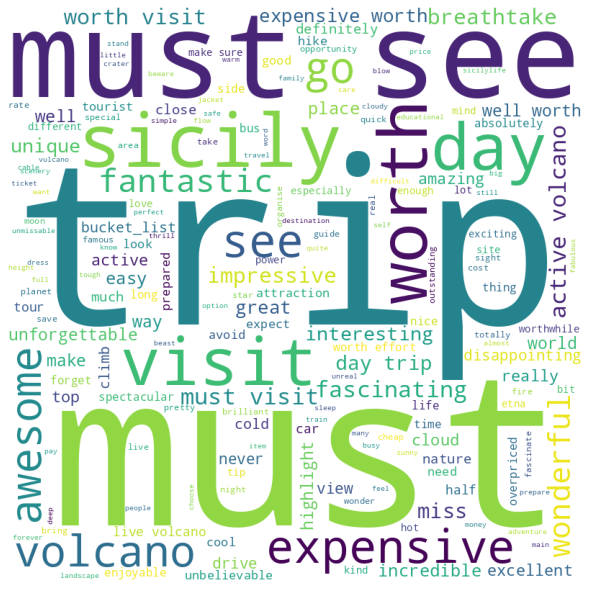

----------------------------------


Wordcloud for Title_Topic_1
0    681
Name: Title_sentiment_rating, dtype: int64


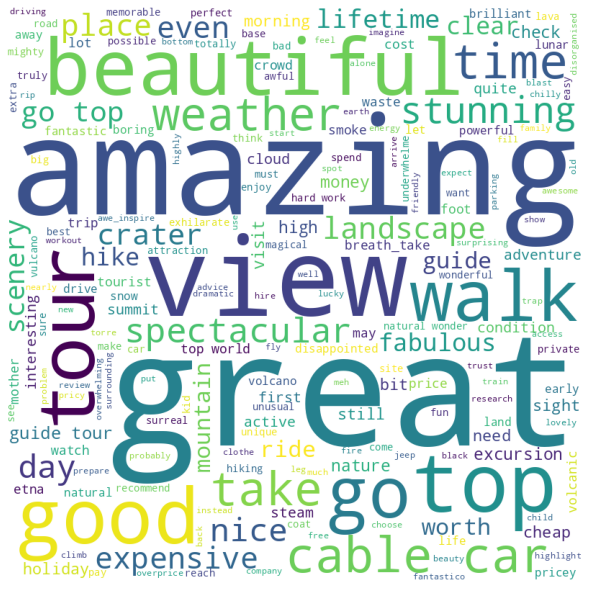

----------------------------------




In [27]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 0]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT NEGATIVE

Wordcloud for Title_Topic_0
1    112
Name: Title_sentiment_rating, dtype: int64


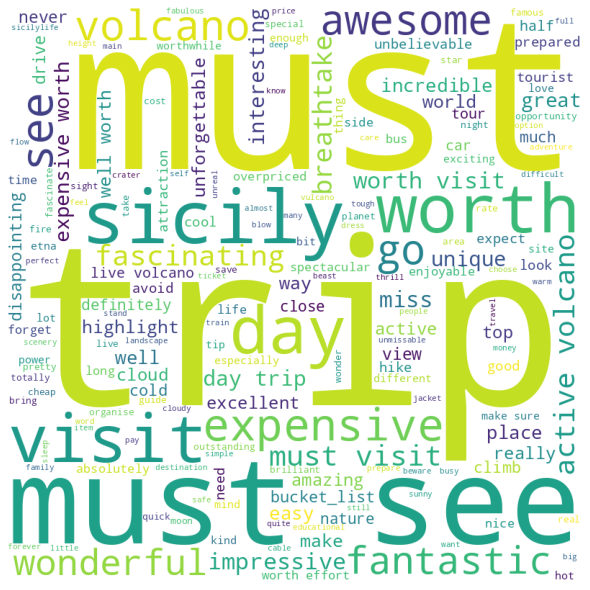

----------------------------------


Wordcloud for Title_Topic_1
1    90
Name: Title_sentiment_rating, dtype: int64


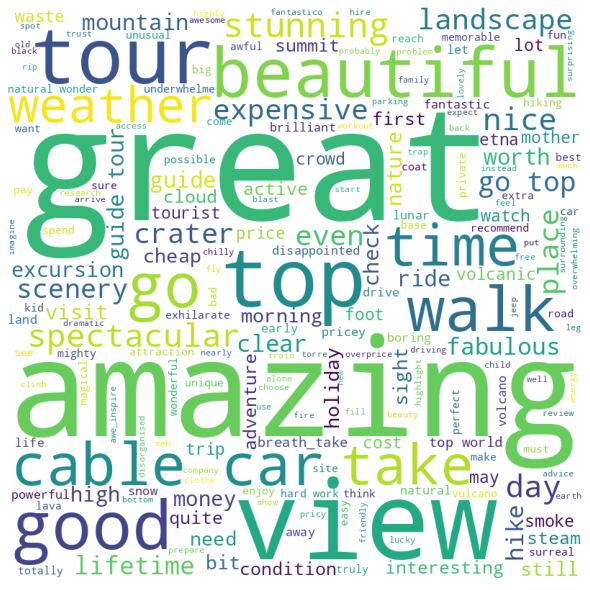

----------------------------------




In [28]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 1]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [29]:
# Evaluation of the model
evaluate_model(lda_title_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [30]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0                                   hard                       0   
1     must see active volcano least life                       0   
2                     cost cable car top                       0   
3                  orgainise easy access                       0   
4                         cheap easy way                       0   
...                                  ...                     ...   
1942                                rock                       0   
1943                              unique                       0   
1944                       fabulous tour                       0   
1945                            exciting                       0   
1946           take time enjoy adventure                       0   

      Title_Topic_0  Title_Topic_1 Title_Dominant_Topic  \
0          0.254582       0.745418              Topic_1   
1          0.924613       0.075387              Topic_0   
2          0.100452       0.899548              Topic_1   
3          0.314285       0.685715              Topic_1   
4          0.618705       0.381295              Topic_0   
...             ...            ...                  ...   
1942       0.257177       0.742823              Topic_1   
1943       0.749340       0.250660              Topic_0   
1944       0.167242       0.832758              Topic_1   
1945       0.745532       0.254468              Topic_0   
1946       0.102980       0.897020              Topic_1   

      Title_Perc_Dominant_Topic  
0                          0.75  
1                          0.92  
2                          0.90  
3                          0.69  
4                          0.62  
...                         ...  
1942                       0.74  
1943                       0.75  
1944                       0.83  
1945                       0.75  
1946                       0.90  

[1947 rows x 6 columns]

In [31]:
lda_title_data_tuned.to_csv(base_dir + 'data/lda_title_data_tuned.csv', index=False)

In [32]:
save_model(lda_title_tuned, base_dir + 'models/model_title_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7f1a3c388e20>,
 '../models/model_title_jupyter.pkl')

# 4. NLP for review

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            1947 non-null   object
 1   title             1947 non-null   object
 2   content           1947 non-null   object
 3   rating            1947 non-null   int64 
 4   sentiment_rating  1947 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 76.2+ KB


In [34]:
noise_words_review = []
token_lists_review = [word_tokenize(each) for each in data['content']]
tokens_review = [item for sublist in token_lists_review for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_review)))


Number of unique tokens then:  13222


In [35]:
one_percentile_review = int(len(set(tokens_review)) * 0.01)
top_1_percentile_review = Counter(tokens_review).most_common(one_percentile_review)
bottom_1_percentile_review = Counter(tokens_review).most_common()[-one_percentile_review:]

print(top_1_percentile_review[:10])
print('---------------')
print(bottom_1_percentile_review[:10])

[('the', 16741), ('.', 12330), (',', 10044), ('to', 9095), ('and', 8532), ('a', 7121), ('of', 4804), ('you', 4331), ('was', 3518), ('is', 3498)]
---------------
[('40-minutes', 1), ('lagged', 1), ('scrambled', 1), ('instead.', 1), ('owed', 1), ('Rifuga', 1), ('tikets', 1), ('on-site', 1), ('ice/snow', 1), ('trees/grass', 1)]


In [36]:
noise_words_review.extend(eng_stop_words)
noise_words_review.extend([word for word, val in top_1_percentile_review])
noise_words_review.extend([word for word, val in bottom_1_percentile_review])

In [37]:
data

author                                              title  \
0              Teithiwr                         A hard climb, but worth it   
1     elizabethlascheid  You must see an active volcano at least once i...   
2                Anne N                    Cost of cable car to the top???   
3         doorstomanual                       Well orgainised, easy access   
4              Emilie P                   Cheap and easy way to do Mt Etna   
...                 ...                                                ...   
1942        DianaMary60                                        Rocks rock!   
1943            Yaron S                                  Unique experience   
1944            jpg1747                                      Fabulous Tour   
1945              qio_s                                 Exciting adventure   
1946         Hornepayne             Take your Time and Enjoy the Adventure   

                                                content  rating  \
0     August 2008. Arrived at Refugio Sapienza just ...       4   
1     Mount Etna is extraordinary. It is an active v...       5   
2     How much does the cable car cost from Rifugio ...       4   
3     We visited Etna with two small children in Aug...       5   
4     We were able to experience Mt Etna without spe...       5   
...                                                 ...     ...   
1942  I went in a 4-wheel drive car, in company with...       5   
1943  Very unique experience. It's not every day you...       5   
1944  We were a group of 7 - we had a great time vis...       5   
1945  I've been to Catania for 5 months with Erasmus...       5   
1946  Went on 3 different tours with Sicily Life. As...       5   

      sentiment_rating  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1942                 0  
1943                 0  
1944                 0  
1945                 0  
1946                 0  

[1947 rows x 5 columns]

In [38]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['content', 'sentiment_rating']],  
                 target = 'content',
                 session_id = 42,
                 custom_stopwords = noise_words_review
                )

In [39]:
lda_review = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review)
lda_review_data = assign_model(lda_review)

In [40]:
print('Shape of lda_review_data: ', lda_review_data.shape)
display(lda_review_data.head())
print('------')
lda_review_data.describe(include='all')

Shape of lda_review_data:  (1947, 8)


content  sentiment_rating  \
0  arrive make_sure allow plenty road long think ...                 0   
1  extraordinary active beautiful landscape ever ...                 0   
2  charge look receipt entry blog say cost say po...                 0   
3  small child august use company sight however o...                 0   
4  able spend money research plenty euro leave re...                 0   

    Topic_0   Topic_1   Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.419645  0.046059  0.533115  0.001180        Topic 2                 0.53  
1  0.650105  0.336696  0.006660  0.006540        Topic 0                 0.65  
2  0.023240  0.930305  0.023370  0.023085        Topic 1                 0.93  
3  0.006581  0.980353  0.006650  0.006416        Topic 1                 0.98  
4  0.019075  0.330222  0.632649  0.018054        Topic 2                 0.63

------


content  sentiment_rating      Topic_0      Topic_1      Topic_2  \
count     1947       1947.000000  1947.000000  1947.000000  1947.000000   
unique    1943               NaN          NaN          NaN          NaN   
top                          NaN          NaN          NaN          NaN   
freq         5               NaN          NaN          NaN          NaN   
mean       NaN          0.103749     0.205116     0.367082     0.325046   
std        NaN          0.305013     0.314659     0.378403     0.372415   
min        NaN          0.000000     0.001067     0.001071     0.000703   
25%        NaN          0.000000     0.008845     0.013938     0.011960   
50%        NaN          0.000000     0.019443     0.236709     0.097777   
75%        NaN          0.000000     0.329735     0.734101     0.641911   
max        NaN          1.000000     0.996829     0.994599     0.995355   

            Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   1947.000000           1947          1947.000000  
unique          NaN              4                  NaN  
top             NaN        Topic 1                  NaN  
freq            NaN            749                  NaN  
mean       0.102756            NaN             0.794782  
std        0.215386            NaN             0.182425  
min        0.000472            NaN             0.250000  
25%        0.006861            NaN             0.640000  
50%        0.012953            NaN             0.870000  
75%        0.035587            NaN             0.960000  
max        0.987126            NaN             1.000000

## Tuning number of topics

In [41]:
tuned_lda_review = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 2 | AUC : 0.6774


In [42]:
lda_review_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_review.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review_tuned)
lda_review_data_tuned = assign_model(lda_review_tuned)
lda_review_data_tuned = lda_review_data_tuned.add_prefix('Review_')
lda_review_data_tuned['Review_Dominant_Topic'] = lda_review_data_tuned['Review_Dominant_Topic'].replace(' ', '_', regex=True)

In [43]:
print('Shape of lda_review_data_tuned: ', lda_review_data_tuned.shape)
display(lda_review_data_tuned.head())
print('------')
lda_review_data_tuned.describe(include='all')

Shape of lda_review_data_tuned:  (1947, 6)


Review_content  Review_sentiment_rating  \
0  arrive make_sure allow plenty road long think ...                        0   
1  extraordinary active beautiful landscape ever ...                        0   
2  charge look receipt entry blog say cost say po...                        0   
3  small child august use company sight however o...                        0   
4  able spend money research plenty euro leave re...                        0   

   Review_Topic_0  Review_Topic_1 Review_Dominant_Topic  \
0        0.437937        0.562063               Topic_1   
1        0.977420        0.022580               Topic_0   
2        0.061737        0.938263               Topic_1   
3        0.018779        0.981221               Topic_1   
4        0.074511        0.925489               Topic_1   

   Review_Perc_Dominant_Topic  
0                        0.56  
1                        0.98  
2                        0.94  
3                        0.98  
4                        0.93

------


Review_content  Review_sentiment_rating  Review_Topic_0  \
count            1947              1947.000000     1947.000000   
unique           1943                      NaN             NaN   
top                                        NaN             NaN   
freq                5                      NaN             NaN   
mean              NaN                 0.103749        0.410484   
std               NaN                 0.305013        0.363105   
min               NaN                 0.000000        0.007149   
25%               NaN                 0.000000        0.056217   
50%               NaN                 0.000000        0.298608   
75%               NaN                 0.000000        0.790602   
max               NaN                 1.000000        0.994620   

        Review_Topic_1 Review_Dominant_Topic  Review_Perc_Dominant_Topic  
count      1947.000000                  1947                 1947.000000  
unique             NaN                     2                         NaN  
top                NaN               Topic_1                         NaN  
freq               NaN                  1179                         NaN  
mean          0.589516                   NaN                    0.844571  
std           0.363105                   NaN                    0.145041  
min           0.005380                   NaN                    0.500000  
25%           0.209398                   NaN                    0.740000  
50%           0.701392                   NaN                    0.910000  
75%           0.943783                   NaN                    0.960000  
max           0.992851                   NaN                    0.990000

In [44]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     extraordinary active beautiful landscape ever ...   
2     charge look receipt entry blog say cost say po...   
3     small child august use company sight however o...   
4     able spend money research plenty euro leave re...   
...                                                 ...   
1942  family old member party year absolutely brilli...   
1943  unique chance climb active expensive sure dres...   
1944         group place big luca entertaining informed   
1945  program active occasionally explode kilometer ...   
1946  different sicily life provide transportation o...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.437937        0.562063   
1                           0        0.977420        0.022580   
2                           0        0.061737        0.938263   
3                           0        0.018779        0.981221   
4                           0        0.074511        0.925489   
...                       ...             ...             ...   
1942                        0        0.383946        0.616054   
1943                        0        0.177363        0.822637   
1944                        0        0.100188        0.899812   
1945                        0        0.976502        0.023498   
1946                        0        0.983728        0.016272   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.56  
1                  Topic_0                        0.98  
2                  Topic_1                        0.94  
3                  Topic_1                        0.98  
4                  Topic_1                        0.93  
...                    ...                         ...  
1942               Topic_1                        0.62  
1943               Topic_1                        0.82  
1944               Topic_1                        0.90  
1945               Topic_0                        0.98  
1946               Topic_0                        0.98  

[1947 rows x 6 columns]

## Wordclouds, bigrams and trigrams for Reviews

Wordcloud for Review_Topic_0
0    657
1    111
Name: Review_sentiment_rating, dtype: int64


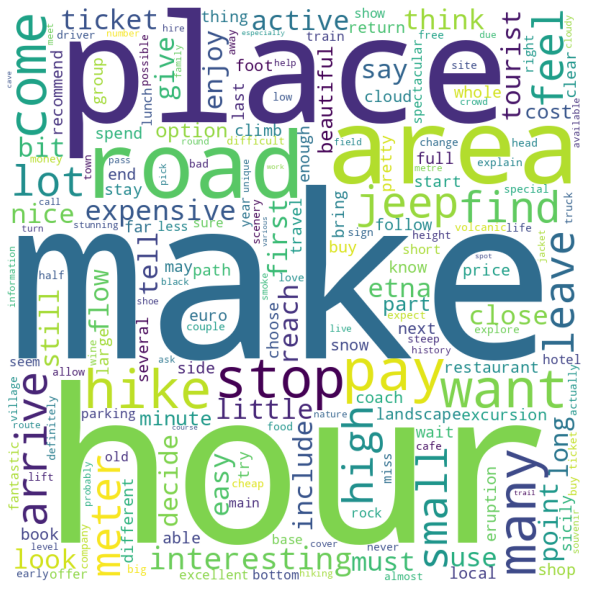

----------------------------------


Wordcloud for Review_Topic_1
0    1088
1      91
Name: Review_sentiment_rating, dtype: int64


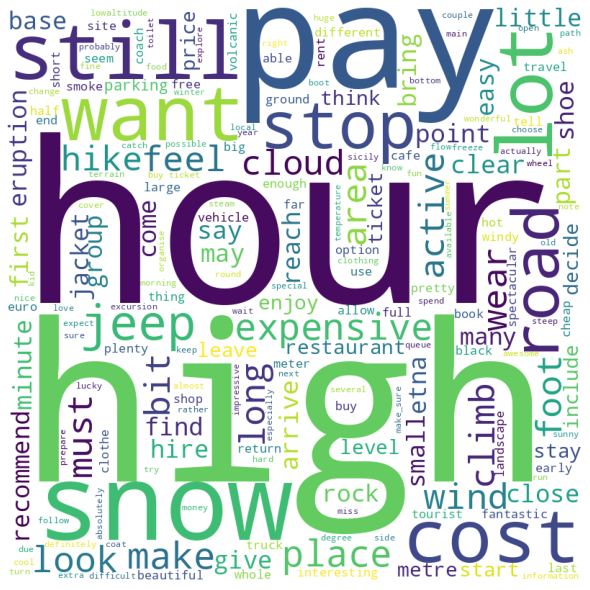

----------------------------------




In [45]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT POSITIVE

Wordcloud for Review_Topic_0
0    657
Name: Review_sentiment_rating, dtype: int64


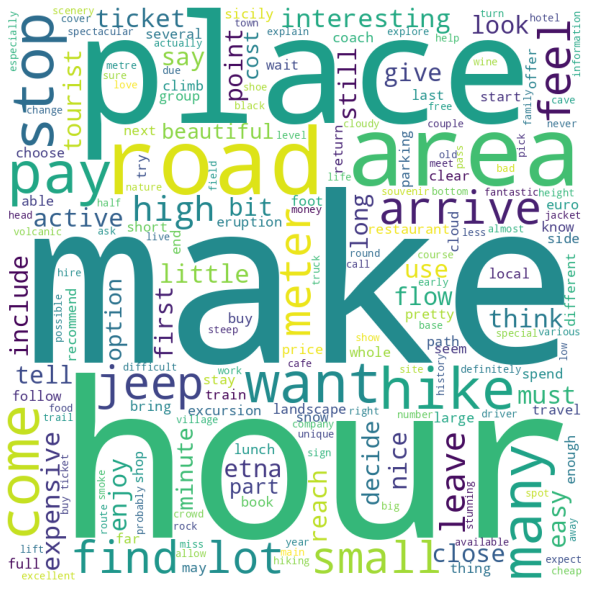

----------------------------------


Wordcloud for Review_Topic_1
0    1088
Name: Review_sentiment_rating, dtype: int64


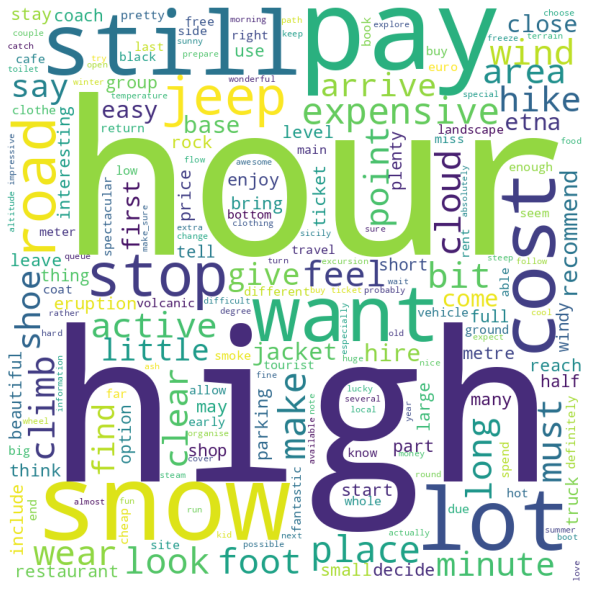

----------------------------------




In [46]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 0]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT NEGATIVE

Wordcloud for Review_Topic_0
1    111
Name: Review_sentiment_rating, dtype: int64


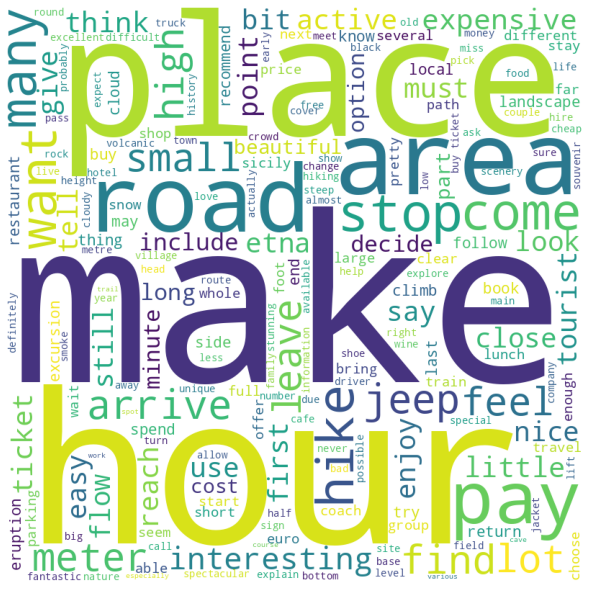

----------------------------------


Wordcloud for Review_Topic_1
1    91
Name: Review_sentiment_rating, dtype: int64


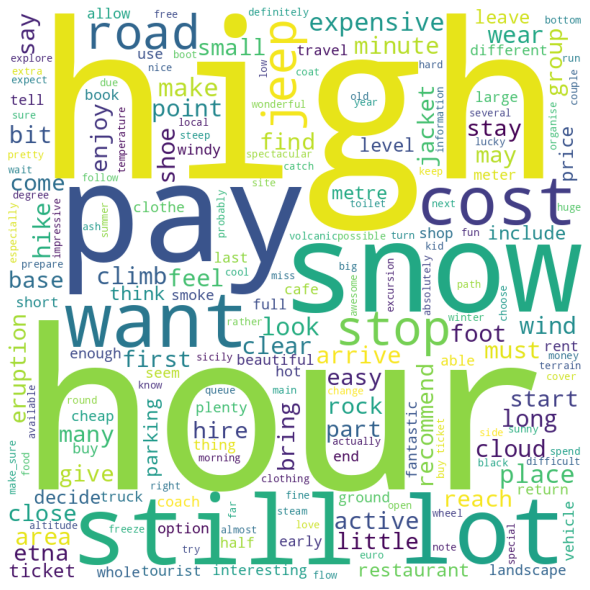

----------------------------------




In [47]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 1]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [48]:
# Evaluation of the model
evaluate_model(lda_review_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [49]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     extraordinary active beautiful landscape ever ...   
2     charge look receipt entry blog say cost say po...   
3     small child august use company sight however o...   
4     able spend money research plenty euro leave re...   
...                                                 ...   
1942  family old member party year absolutely brilli...   
1943  unique chance climb active expensive sure dres...   
1944         group place big luca entertaining informed   
1945  program active occasionally explode kilometer ...   
1946  different sicily life provide transportation o...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.437937        0.562063   
1                           0        0.977420        0.022580   
2                           0        0.061737        0.938263   
3                           0        0.018779        0.981221   
4                           0        0.074511        0.925489   
...                       ...             ...             ...   
1942                        0        0.383946        0.616054   
1943                        0        0.177363        0.822637   
1944                        0        0.100188        0.899812   
1945                        0        0.976502        0.023498   
1946                        0        0.983728        0.016272   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.56  
1                  Topic_0                        0.98  
2                  Topic_1                        0.94  
3                  Topic_1                        0.98  
4                  Topic_1                        0.93  
...                    ...                         ...  
1942               Topic_1                        0.62  
1943               Topic_1                        0.82  
1944               Topic_1                        0.90  
1945               Topic_0                        0.98  
1946               Topic_0                        0.98  

[1947 rows x 6 columns]

In [50]:
lda_review_data_tuned.to_csv(base_dir + 'data/lda_review_data_tuned.csv', index=False)

In [51]:
save_model(lda_review_tuned, base_dir + 'models/model_review_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7f1998c193d0>,
 '../models/model_review_jupyter.pkl')

In [52]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     extraordinary active beautiful landscape ever ...   
2     charge look receipt entry blog say cost say po...   
3     small child august use company sight however o...   
4     able spend money research plenty euro leave re...   
...                                                 ...   
1942  family old member party year absolutely brilli...   
1943  unique chance climb active expensive sure dres...   
1944         group place big luca entertaining informed   
1945  program active occasionally explode kilometer ...   
1946  different sicily life provide transportation o...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.437937        0.562063   
1                           0        0.977420        0.022580   
2                           0        0.061737        0.938263   
3                           0        0.018779        0.981221   
4                           0        0.074511        0.925489   
...                       ...             ...             ...   
1942                        0        0.383946        0.616054   
1943                        0        0.177363        0.822637   
1944                        0        0.100188        0.899812   
1945                        0        0.976502        0.023498   
1946                        0        0.983728        0.016272   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.56  
1                  Topic_0                        0.98  
2                  Topic_1                        0.94  
3                  Topic_1                        0.98  
4                  Topic_1                        0.93  
...                    ...                         ...  
1942               Topic_1                        0.62  
1943               Topic_1                        0.82  
1944               Topic_1                        0.90  
1945               Topic_0                        0.98  
1946               Topic_0                        0.98  

[1947 rows x 6 columns]